In [53]:
import time
import csv
import os
import features
import numpy as np
import skimage.io
import matplotlib.pyplot as plt
import cPickle as pickle
import itertools as it
import more_itertools as mit

import multiprocessing
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
TRAINING_FOLDER = "/Users/vt/Code/Internal/lab-gaze-tracker/training_data/company-day-oct-23/"

# Gaze vector and failure extraction

In [36]:
# Each image will have its gaze vector extracted for each face detected in the image.
# Failures will also be reported (face_detection_error, left/right_pupil_error)
#
# Row Format:
# file_path,failure1:failure2:failure3,x1,x2,...

def file_to_gaze_vector_with_erorrs_csv_rows(file_path):
    frame = skimage.io.imread(file_path)
    dets = features.FaceDetection.calculate(frame)
    
    if not dets:
        return [(file_path, 'face_detection_error')]
    
    rows = []
    
    for det in dets:
        failures = []

        landmarks = features.FaceLandmarks.calculate(frame, det)
        orientation = features.HeadOrientation.calculate(frame, landmarks)
        eye_roi = features.EyeRegions.calculate(landmarks)
        left_pupil = features.IrisFinder.calculate(frame, eye_roi.left)
        right_pupil = features.IrisFinder.calculate(frame, eye_roi.right)
        ellipses = features.EyeEllipses.calculate(landmarks)
        
        if left_pupil == ((0,0), 0):
            failures.append('left_pupil_error')
        if right_pupil == ((0,0), 0):
            failures.append('right_pupil_error')

        vector = features.GazeMatrix.calculate(
            landmarks,
            orientation,
            ellipses,
            left_pupil,
            right_pupil
        )

        rows.append([file_path, ':'.join(failures)] + vector)
        
    # file_path,failure1:failure2:failure3,x1,x2,...
    return rows

In [4]:
TRAINING_DATA_DIR = '/Users/vt/Code/Internal/lab-gaze-tracker/training_data/company-day-oct-23'
rejected_dirs = (
#     'back_left', 'back_right', 'back_center',
#     'front_center', 'front_left', 'front_right',
#     'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18',
#     'p19', 'p20', 'p21', 'p22', 'p23', 'p9', 'p8', 'p7', 'p6', 'p5',
#     'p4', 'p3', 'p2', 'p2-glasses'
)
training_files = []
for root, dirs, files in os.walk(TRAINING_DATA_DIR):
    filtered_files = (f for f in files if f != '.DS_Store')
    for file_ in filtered_files:
        training_files.append(os.path.join(root, file_))
        
    for rd in rejected_dirs:
        if rd in dirs:
            dirs.remove(rd)

**Note: The following process takes around 3 hours.**

In [49]:
print "Time started:", time.time()

out_file = open('gaze_vectors_with_failures.csv', 'w')
writer = csv.writer(out_file)
for file_path in training_files:
    writer.writerows(file_to_gaze_vector_with_erorrs_csv_rows(file_path))
    out_file.flush()

print "Time ended:", time.time()

Time started: 1446664304.08
Time ended: 1446674046.48


## Dataset Analysis

In [77]:
in_file = open('gaze_vectors_with_failures.csv', 'rb')
all_vectors = list(csv.reader(in_file))
complete_vectors = [(row[0],row[2:]) for row in all_vectors if not row[1]]

def failures(rows):
    for row in rows:
        if row[1]:
            for failure in row[1].split(':'):
                yield failure

print "Total number of files:\t", len(training_files)
print "Total vectors:\t\t", len(all_vectors) #There may be multiple faces in a file so it is ok for Total Vectors > no. of files
print "Complete vectors:\t", len(complete_vectors) 
print ""
print "Left Pupil errors:\t", sum((1 for f in failures(all_vectors) if f == 'left_pupil_error'))
print "Right Pupil errors:\t", sum((1 for f in failures(all_vectors) if f == 'right_pupil_error'))
print "Face detection errors:\t", sum((1 for f in failures(all_vectors) if f == 'face_detection_error'))

Total number of files:	20909
Total vectors:		21104
Complete vectors:	17372

Left Pupil errors:	51
Right Pupil errors:	11
Face detection errors:	3678


# Failure Modes

In [5]:
def file_to_gaze_vector(file_path):
    frame = skimage.io.imread(file_path)
    for det in features.FaceDetection.calculate(frame):
        plt.figure()
        landmarks = features.FaceLandmarks.calculate(frame, det)
        plt.imshow(features.FaceLandmarks.show(frame, landmarks))

        orientation = features.HeadOrientation.calculate(frame, landmarks)
        eye_roi = features.EyeRegions.calculate(landmarks)
        left_pupil = features.IrisFinder.calculate(frame, eye_roi.left)
        right_pupil = features.IrisFinder.calculate(frame, eye_roi.right)
        ellipses = features.EyeEllipses.calculate(landmarks)

        return features.GazeMatrix.calculate(
            landmarks,
            orientation,
            ellipses,
            left_pupil,
            right_pupil
        )

In [6]:
def gaze_vector_and_display(file_path):
    print TRAINING_FOLDER
    full_path = os.path.join(TRAINING_FOLDER, file_path)
    plt.axis('off')
    plt.imshow(skimage.io.imread(full_path))
    print "Gaze vector result:", file_to_gaze_vector(full_path)

## Face Detection

The following is an example of the face being too small in the photo for dlib's face detector.

/Users/vt/Code/Internal/lab-gaze-tracker/training_data/company-day-oct-23/
Gaze vector result: None


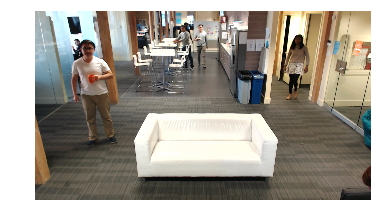

In [7]:
gaze_vector_and_display("p4/back_left/frame_637_top_left_natural.jpg")

The following failure occurs most likely due to the face being tilted too much.

/Users/vt/Code/Internal/lab-gaze-tracker/training_data/company-day-oct-23/
Gaze vector result: None


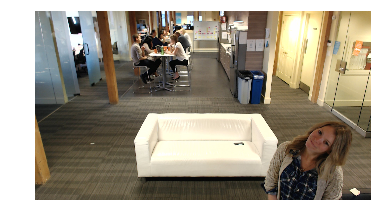

In [8]:
gaze_vector_and_display("p18/front_right/frame_203_top_left_natural.jpg")

## Facial Landmarks Detection

The following experiments attempt to make facial keypoint detection fail by providing no face at all.

In [9]:
def fail_landmarks(file_path1, file_path2):
    frame1 = skimage.io.imread(os.path.join(TRAINING_FOLDER, file_path1))
    frame2 = skimage.io.imread(os.path.join(TRAINING_FOLDER, file_path2))
    dets = features.FaceDetection.calculate(frame1)
    for det in dets:
        plt.figure()
        plt.title('Face region 1 displayed on Frame 1')
        plt.axis('off')
        plt.imshow(features.FaceDetection.show(frame1, dets))
        
        plt.figure()
        plt.title('Face region 1 displayed on Frame 2')
        plt.axis('off')
        plt.imshow(features.FaceDetection.show(frame2, dets))
        
        true_landmarks = features.FaceLandmarks.calculate(frame1, det)
        erroneous_landmarks = features.FaceLandmarks.calculate(frame2, det)
        print erroneous_landmarks
        
        plt.figure()
        plt.title('Face region 1 used to detect landmarks \n in Frame 2 (Erroneous Landmarks)')
        plt.axis('off')
        plt.imshow(features.FaceLandmarks.show(frame2, erroneous_landmarks))
                  
        plt.figure()
        plt.title('Erroneous Landmarks displayed on Frame 1')
        plt.axis('off')
        plt.imshow(features.FaceLandmarks.show(frame1, erroneous_landmarks))
        
        plt.figure()
        plt.title('Face region 1 used to detect landmarks \n in Frame 1 (True Landmarks)')
        plt.axis('off')
        plt.imshow(features.FaceLandmarks.show(frame1, true_landmarks))

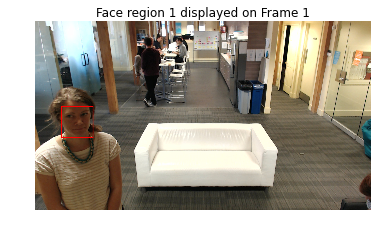

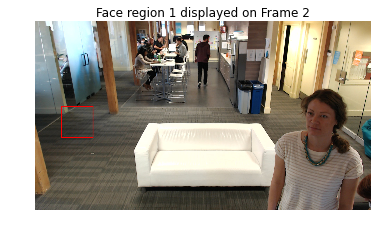

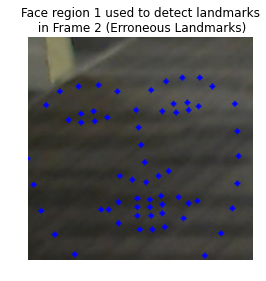

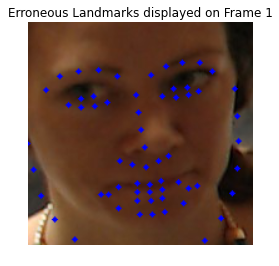

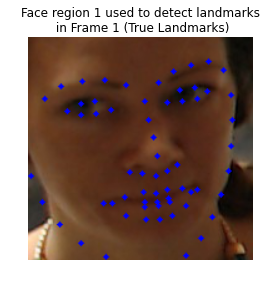

In [10]:
fail_landmarks("p1/front_left/frame_144_top_left_straight.jpg", "p1/front_right/frame_150_top_left_natural.jpg")

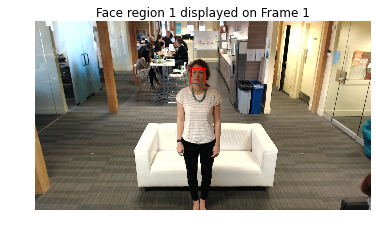

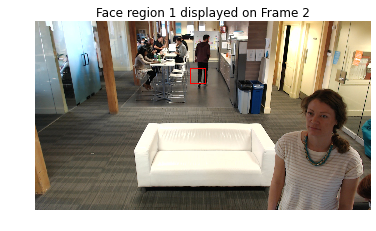

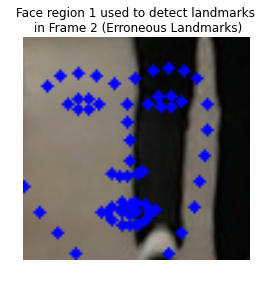

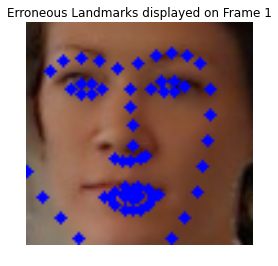

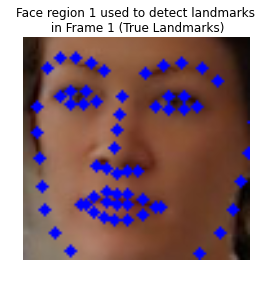

In [11]:
fail_landmarks("p1/middle_center/frame_448_top_left_natural.jpg", "p1/front_right/frame_150_top_left_natural.jpg")

Attempting to use a completely white background:

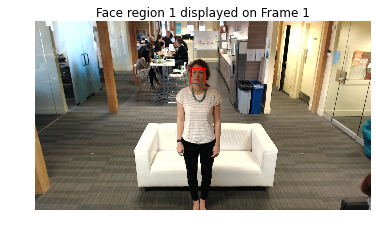

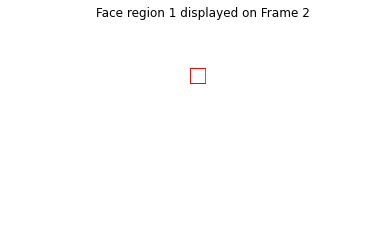

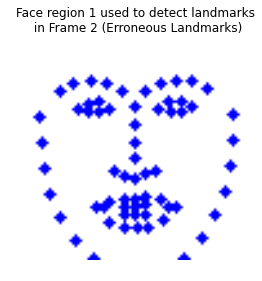

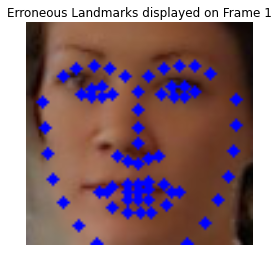

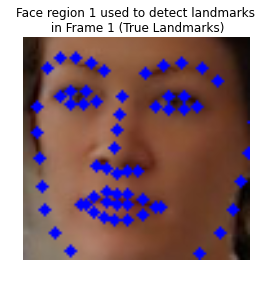

In [12]:
fail_landmarks("p1/middle_center/frame_448_top_left_natural.jpg", "../../notebooks/white.jpeg")